# Brian Larsen - 28 April 2016 balarsen@lanl.gov
# Overview
This is meant to be a proof of concept example of the SWx to Mission instrument prediction planned for AFTAC funding.

## Abstract
There is currently no accepted method within SNDD for the time dependent quantification of environmental background in this mission instruments, this work aims to provide this capability. This work provides a preliminary proof of concept of the techniques in order to both show utility and provide a baseline for improvement. The methods incorporated here are Bayesian MCMC curve fitting and Bayesian posterior sampling. The method is to utilize data of SWx and mission instruments to find (linear) correlation coefficients using all the data. Then utilizing the relations discovered in the correlation step the predicted response in the mission instruments are then created. 

## Goals
1. Provide a quantifiable prediction of count rate in the mission instruments
   1. Need to study which data are required to provide the best prediction
   1. First step is beginning with data moving toward prediction, second step is a first principle assessment of background based on SAGE
1. Provide an automatic method to determine a quantifiable deviation from the prediction in order to determine Events of Interest (EOI)
1. Provide an update and future capability into the method for update and reassessment of accuracy and addition of additional data 
1. Provide mechanisms for the inclusion of the model and prediction rules into DIORAMA without DIORAMA having to run MCMC.



### The Steps are
1. Perform a correlation analysis between the two data sets figuring out which variables make the best prediction
1. Use the results of this correlation to predict the response for the Mission instrument from the SWx
1. Utilize the predicted response to determine quantifiable count rate prediction limits
1. Develop a technique to quantify excursions of the observed data from the predicted limits to flag as EOI with an interest score

In [1]:
!date

Thu Apr 28 10:38:40 MDT 2016


In [2]:
# Standard Library Python Modules

# Common Python Modules
import matplotlib.pyplot as plt
import numpy as np
import spacepy.plot as spp
import spacepy.toolbox as tb
import pandas as pd
import pymc # this is the MCMC tool

# put plots into this document
%matplotlib inline

This unreleased version of SpacePy is not supported by the SpacePy team.


/Users/blarsen/miniconda3/envs/python3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Create simulated data that can be used in this proof of concept

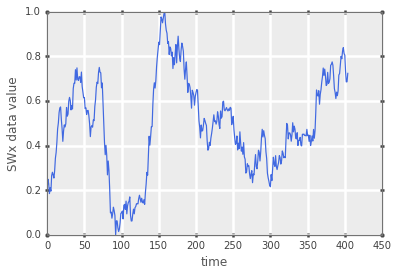

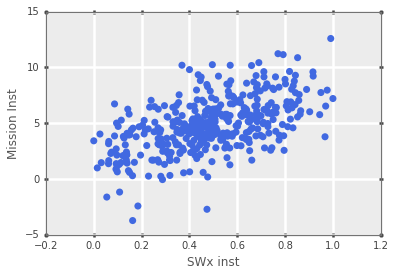

In [3]:
# observed data

from scipy.signal import savgol_filter
# make a time dependent x
t_x = np.random.uniform(0, 1, 500)
t_x = savgol_filter(t_x, 95, 2)[95//2:-95//2]
t_x -= t_x.min()
t_x /= (t_x.max() - t_x.min())
plt.plot(t_x)
plt.xlabel('time')
plt.ylabel('SWx data value')

a = 6
b = 2
sigma = 2.0
y_obs = a*t_x + b + np.random.normal(0, sigma, len(t_x))
data = pd.DataFrame(np.array([t_x, y_obs]).T, columns=['x', 'y'])

x = t_x

data.plot(x='x', y='y', kind='scatter', s=50)
plt.xlabel('SWx inst')
plt.ylabel('Mission Inst')

In [4]:


# define priors
a = pymc.Normal('slope', mu=0, tau=1.0/10**2)
b = pymc.Normal('intercept', mu=0, tau=1.0/10**2)
tau = pymc.Gamma("tau", alpha=0.1, beta=0.1)

# define likelihood
@pymc.deterministic
def mu(a=a, b=b, x=x):
    return a*x + b



y = pymc.Normal('y', mu=mu, tau=tau, value=y_obs, observed=True)


In [5]:

# inference
m = pymc.Model([a, b, tau, x, y])
mc = pymc.MCMC(m)
# run 6 chains
for i in range(6):
    mc.sample(iter=90000, burn=10000)



 [-----------------100%-----------------] 90000 of 90000 complete in 15.8 sec

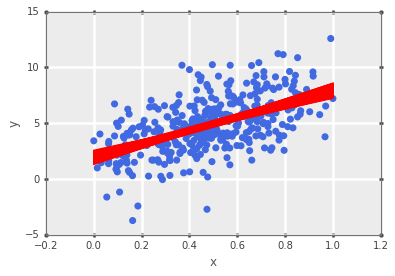

In [6]:
# plot up the data and overplot the possible fit lines

data.plot(x='x', y='y', kind='scatter', s=50)

xx = np.linspace(data.x.min(), data.x.max(), 10)
for ii in range(0, len(mc.trace('slope', chain=None)[:]), 
                len(mc.trace('slope', chain=None)[:])//400):
    yy = (xx*mc.trace('slope', chain=None)[:][ii] + 
          mc.trace('intercept', chain=None)[:][ii])
    plt.plot(xx,yy, c='r')
    


Plotting slope
Plotting tau
Plotting intercept


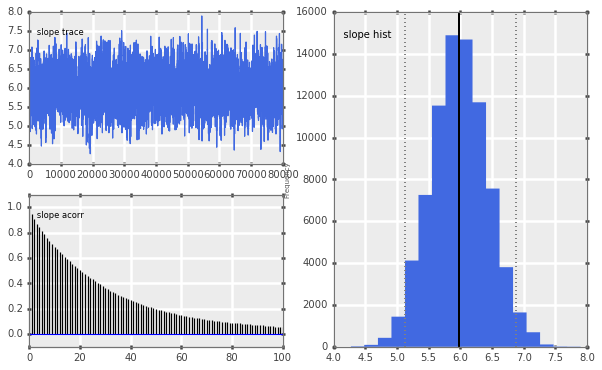

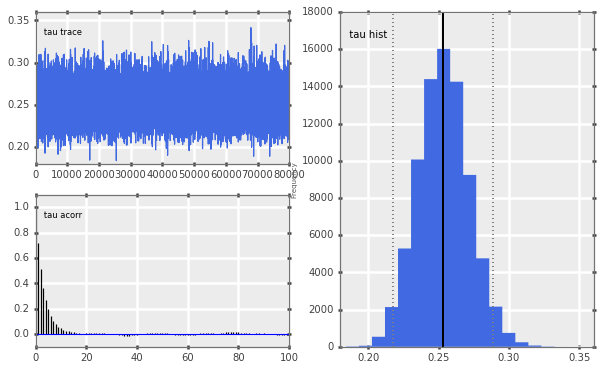

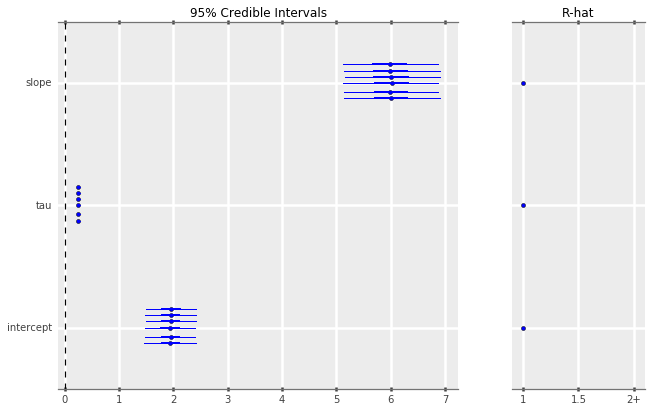

In [7]:

pymc.Matplot.plot(mc)
pymc.Matplot.summary_plot(mc)



Now based on the results above we can use this as a prediction of the Y-data from the X-data into the future

Now that we have time dependent data use the results from the above correlation to predict what the Y-instrument would have seen

In [8]:
int_vals = mc.stats()['intercept']['95% HPD interval']
slope_vals = mc.stats()['slope']['95% HPD interval']
print(int_vals, slope_vals)

/Users/blarsen/miniconda3/envs/python3/lib/python3.4/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


[ 1.48217792  2.41733421] [ 5.12765884  6.88271888]


In [9]:
y_inst =  np.tile(t_x, (2,1)).T * slope_vals + int_vals

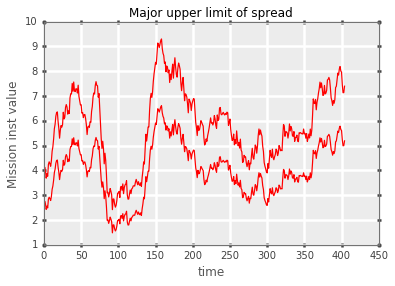

In [10]:
plt.plot(y_inst, c='r')
plt.xlabel('time')
plt.ylabel('Mission inst value')
plt.title('Major upper limit of spread')


Or do this smarter by sampling the posterior

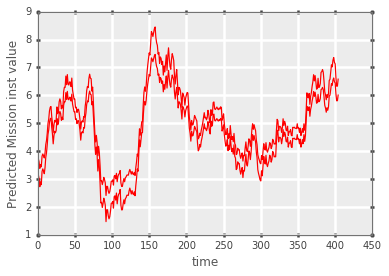

In [11]:
pred = []
for v in t_x:
    pred.append(np.percentile(v * mc.trace('slope', 
                                           chain=None)[:] + 
                              mc.trace('intercept', 
                                       chain=None)[:], 
                              [2.5, 97.5]))
plt.plot(pred, c='r')
plt.xlabel('time')
plt.ylabel('Predicted Mission inst value')

# Next steps
1. Statistically validate and/or modify this proof of concept. 
1. Determine how to quantify the prediction capability
1. Determine methods to identify EOI outside of prediction
# Issues
* The overall spread in the data are not captured (enveloped) by this proof of concept

# Another possible method
For each value of X (or small range of X) fit a distribution to the Y (what kind?) and use that as a prediction. This is maybe not as good as there is likely to not be continous. 